In [750]:
import networkx as nx
import osmnx as ox
import numpy as np
import warnings
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
 
logging.basicConfig(filename = 'planner_v3.log',
                    filemode="w",
                    level = logging.DEBUG,
                    format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')

logging.info("Start of the program")

warnings.filterwarnings('ignore')

In [751]:
tube_color_dict = {
	'Bakerloo': "#ae6118",
	'Central': "#ae6118",
	'District': "#00a575",
	'Circle': "#f8d42d",
    'DLR': "#00bbb4",
    'Hammersmith and City': "#e899a8",
	'Jubilee': "#8f989e",
	'Metropolitan': "#893267",
	'Northern': "#1C1C1C",
    'Overground': "#F86C00",
	'Piccadilly': "#0450a1",
	'Victoria': "#009fe0",
	'Waterloo and City': "#70c3ce",
    'Elizabeth': "#603E99"
}

# MAP_PATH = "./data/london.graphml"
# MAP_TUBE_PATH = "./data/london_tube.graphml"

# LONDON_NORTH, LONDON_SOUTH, LONDON_EAST, LONDON_WEST = 51.672343, 51.384940, 0.148271, -0.351468

ACCEPTABLE_WALKING_DISTANCE = 1000 # 1 km
ACCEPTABLE_WALKING_TIME = 15 * 60 # 15 minutes

ENTRY_PENALTY = 3
TRANSFERS_PENALTY = 3
WK_WEIGHT = 0.5

DRAW_MAP = False

WALKING_SPEED = 1.34112 # m/s
WALKING_SPEED_MALE = 1.4 # m/s
WALKING_SPEED_FEMALE = 1.31 # m/s
WALKING_SPEED_YOUNG = 1.45 # m/s
WALKING_SPEED_OLD = 1.19 # m/s

# "Bakerloo": 27.04
# "Central": 37.29
# "Circle": 24.31
# "District": 29.44
# "Hammersmith and City": 27.65
# "Jubilee": 40.32
# "Metropolitan": 44.14
# "Northern": 34.09
# "Piccadilly": 32.65
# "Victoria": 42.49
# "Waterloo and City": 33.30

# TP_SPEED_ADJUSTMENT = 0 # km/h
tube_speeds = [27.04, 37.29, 24.31, 29.44, 27.65, 40.32, 44.14, 34.09, 32.65, 42.49, 33.30]
TRANSPORT_SPEED =  np.mean(tube_speeds) / 3.6 # km/h to m/s

user_group = ''
TRANSPORT_SPEED

9.412121212121212

In [752]:
# origin_address = 'Finchley Road Station, London, UK'
# dest_address = 'Covent Garden, London, UK'

# origin_address = 'Finchley Road Station, London, UK'
# dest_address = 'Bush House, London, UK'

origin_address = "Paddington Station, London, UK"
dest_address = 'Bush House, London, UK'

# origin_address = "Madame Tussauds London, London, UK"
# dest_address = 'Park Royal, London, UK'

# origin_address = "Lancaster Gate, London, UK"
# dest_address = 'Natural History Museum, London, UK'

# origin_address = "Euston Station, London, UK"
# dest_address = 'Natural History Museum, London, UK'

# origin_address = 'Canary Wharf Station, London, UK'
# dest_address = 'British Museum, London, UK'


address_compact = origin_address.split(",")[0].replace(" ", "_") + '-' + dest_address.split(",")[0].replace(" ", "_")
origin_lat, origin_lon = ox.geocode(origin_address)
dest_lat, dest_lon = ox.geocode(dest_address)

In [753]:
def get_bbox_bound_from_coord(lat1, lon1, lat2, lon2):
    north, south, east, west = -100, 100, -100, 100
    if lat1 > north: north = lat1
    if lat2 > north: north = lat2
    if lat1 < south: south = lat1
    if lat2 < south: south = lat2
    if lon1 > east: east = lon1
    if lon2 > east: east = lon2
    if lon1 < west: west = lon1
    if lon2 < west: west = lon2

    diff = 0.03
    
    return north+diff, south-diff, east+diff, west-diff

In [754]:
north, south, east, west = get_bbox_bound_from_coord(origin_lat, origin_lon, dest_lat, dest_lon)
G = ox.graph_from_bbox(north, south, east, west, network_type="walk")
# ox.save_graphml(G, MAP_PATH)

In [755]:
origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)

In [756]:
# add weights to walking edges based on age/gender
for u, v, k, data in G.edges(data=True, keys=True):
    # data['color'] = '#AAFF00'
    distance = data["length"]
    data["time"] = round(distance / WALKING_SPEED) * WK_WEIGHT
    data["time_young"] = round(distance / WALKING_SPEED_YOUNG) * WK_WEIGHT
    data["time_old"] = round(distance / WALKING_SPEED_OLD) * WK_WEIGHT
    # data["time_male"] = round(distance / WALKING_SPEED_MALE) * WK_WEIGHT
    # data["time_female"] = round(distance / WALKING_SPEED_FEMALE)  * WK_WEIGHT

G_wk = G.copy()

In [757]:
import json

with open('input/LondonTubeLines_minimal.json', 'r') as f:
    data = json.load(f)

tube_map = {}
station_transfer_nodes = {}
added_nodes_name = set()
stations_osmid = set()

# add new station transfer nodes first
for tube_route in data['features']:
    start_end = tube_route['geometry']['coordinates']
    orig_lon, orig_lat = start_end[0][0], start_end[0][1]
    end_lon, end_lat = start_end[1][0], start_end[1][1]

    orig_node, dist1 = ox.nearest_nodes(G, orig_lon, orig_lat, return_dist=True)
    end_node, dist2 = ox.nearest_nodes(G, end_lon, end_lat, return_dist=True)

    # ignore stations and routes that are not within 50m of the graph
    if dist1 > 50 or dist2 > 50:
        continue

    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    # prepare for station search later
    G.nodes[orig_node]['station_name'] = start_station_name
    G.nodes[end_node]['station_name'] = end_station_name
    stations_osmid.add(orig_node)
    stations_osmid.add(end_node)

    try:
        tube_map[start_station_name].add(line_name)
    except (KeyError, AttributeError) as e:
        tube_map[start_station_name] = {line_name}

    try:
        tube_map[end_station_name].add(line_name)
    except (KeyError, AttributeError) as e:
        tube_map[end_station_name] = {line_name}

    start_node_name = f"{start_station_name} [{line_name}]"
    end_node_name = f"{end_station_name} [{line_name}]"

    if not start_node_name in added_nodes_name:
        new_node = (start_node_name, {'x': G.nodes[orig_node]['x'], 'y': G.nodes[orig_node]['y'], 'type':'tube_station'}) # +0.0001*len(tube_map[start_station_name])
        try:
            station_transfer_nodes[orig_node].append(new_node)
        except (KeyError, AttributeError) as e:
            station_transfer_nodes[orig_node] = [new_node]
        logging.debug(f"{orig_node} add {start_node_name}")
        added_nodes_name.add(start_node_name)
    
    if not end_node_name in added_nodes_name:
        new_node = (end_node_name, {'x': G.nodes[end_node]['x'], 'y': G.nodes[end_node]['y'], 'type':'tube_station'}) # +0.0001*len(tube_map[end_station_name])
        try:
            station_transfer_nodes[end_node].append(new_node)
        except (KeyError, AttributeError) as e:
            station_transfer_nodes[end_node] = [new_node]
        
        logging.debug(f"{end_node} add {end_node_name}")
        added_nodes_name.add(end_node_name)


In [758]:
for station in station_transfer_nodes:
    station_transfers = []
    # add entrances to the station transfer nodes
    for node in station_transfer_nodes[station]:
        G.add_node(node[0], **node[1])
        logging.debug(f"added node {node[0]}: {G.nodes[node[0]]}")
        G.add_edge(station, node[0], **{'length': 0, 'time': ENTRY_PENALTY*60, 'time_young': ENTRY_PENALTY*60, 'time_old': ENTRY_PENALTY*60, 'type': 'entrance'})
        G.add_edge(node[0], station, **{'length': 0, 'time': ENTRY_PENALTY*60, 'time_young': ENTRY_PENALTY*60, 'time_old': ENTRY_PENALTY*60, 'type': 'entrance'})
        logging.debug(f"entrance added: {station} -> {node[0]} {G.edges[station, node[0], 0]}")
        station_transfers.append(node[0])

    # add edges between transfer nodes (within the station)
    for i in range(len(station_transfers)):
        for j in range(i+1, len(station_transfers)):
            G.add_edge(station_transfers[i], station_transfers[j], **{'length': 0, 'time': TRANSFERS_PENALTY*60, 'time_young': ENTRY_PENALTY*60, 'time_old': ENTRY_PENALTY*60, 'type': 'transfer'})
            G.add_edge(station_transfers[j], station_transfers[i], **{'length': 0, 'time': TRANSFERS_PENALTY*60, 'time_young': ENTRY_PENALTY*60, 'time_old': ENTRY_PENALTY*60, 'type': 'transfer'})
            logging.debug(f"transfer added: {station_transfers[i]} -> {station_transfers[j]} {G.edges[station_transfers[j], station_transfers[i], 0]}")

In [759]:
# add tube lines
tube_lines, route_colors = [], []
for tube_route in data['features']:
    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    start_node_name = f"{start_station_name} [{line_name}]"
    end_node_name = f"{end_station_name} [{line_name}]"

    if start_node_name in added_nodes_name and end_node_name in added_nodes_name:
        G.add_edge(start_node_name, end_node_name, color=line_color)
        G.add_edge(end_node_name, start_node_name, color=line_color)

        logging.debug(f"connecting: {start_node_name} to {end_node_name}")
        
        tube_lines.append(nx.shortest_path(G, start_node_name, end_node_name))
        route_colors.append(line_color)

# logging.debug(f"all station info been added\n")
ox.distance.add_edge_lengths(G)

In [760]:
# add weight to tp edges
for u, v, k, data in G.edges(data=True, keys=True):
    if 'time' not in data:
        data["time"] = data["time_young"] = data["time_old"] = round(data["length"] / TRANSPORT_SPEED, 2)
    #     data['travel_mode'] = 'tp'
    #     logging.debug(f"add tp time{data}")
        # data["time"] = data["time_male"] = data["time_female"] = data["time_young"] = data["time_old"] = data["length"] / TRANSPORT_SPEED
        # print(f"distance: {round(data['length'], 3)} m \ttp time: {round(data['time'], 3)} seconds")
        # print(u, v, data)

# print(G.edges['Bank [Waterloo and City]', 'Waterloo [Waterloo and City]', 0])

In [761]:
# plot london tube maps on top of walking map
if DRAW_MAP:
    fig, ax = ox.plot_graph_routes(G, tube_lines, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
                                node_color='w', node_alpha=.3, node_size=.2, orig_dest_size=40, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.3, \
                                dpi=300)

    fig.savefig(f"output_osmnx_paths/tube_map_{address_compact}.png", dpi=300, bbox_inches='tight')

In [762]:
def get_route_colors(G, route):
    route_colors, route_chunks = [], []
    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        route_chunks.append([start_node, end_node])
        if 'color' in G.edges[start_node, end_node, 0]:
            route_colors.append(G.edges[start_node, end_node, 0]['color'])
        else:
            route_colors.append('springgreen')

    return route_chunks, route_colors

In [763]:
def get_bbox_bound(node_list):
    north, south, east, west = -100, 100, -100, 100
    for node in node_list:
        if G.nodes[node]['y'] > north:
            north = G.nodes[node]['y']
        if G.nodes[node]['y'] < south:
            south = G.nodes[node]['y']
        if G.nodes[node]['x'] > east:
            east = G.nodes[node]['x']
        if G.nodes[node]['x'] < west:
            west = G.nodes[node]['x']
    diff_h = 0.01
    diff_v = 0.01
    return north+diff_h, south-diff_h, east+diff_v, west-diff_v


In [764]:
def get_route_description(G, route, debug=True, total_wk_time=0, total_tp_time=0, transfer=0):
    if debug:
        logging.debug(f"Start at : {origin_address}")
    else:
        print(f"Start at : {origin_address}")

    last_travel_mode = 'walk'
    last_station = ''

    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        if 'type' in G.nodes[start_node] and G.nodes[start_node]['type'] == 'tube_station' \
            and 'type' in G.nodes[end_node] and G.nodes[end_node]['type'] == 'tube_station':
            tube_line = start_node.split(' [')[1].split(']')[0]
            station1 = start_node.split(' [')[0]
            station2 = end_node.split(' [')[0]
            
            if last_travel_mode != 'walk' and last_travel_mode != tube_line:
                if debug:
                    logging.debug(f"   -> to [{last_station}]")
                else:
                    print(f"   -> to [{last_station}]")
            last_station = station2
            travel_mode = tube_line
            # record tp time
            total_tp_time += G.edges[start_node, end_node, 0]["time" + user_group]
        elif ('type' in G.nodes[start_node] and G.nodes[start_node]['type'] == 'tube_station') \
            or ('type' in G.nodes[end_node] and G.nodes[end_node]['type'] == 'tube_station'):
            # elif on transfer edges
            travel_mode = 'walk'
            # record wk time
            total_wk_time += G.edges[start_node, end_node, 0]["time" + user_group]
        else:
            travel_mode = 'walk'
            # record wk time
            total_wk_time += G.edges[start_node, end_node, 0]["time" + user_group]/WK_WEIGHT
        
        if last_travel_mode != travel_mode:
            transfer += 1
            if last_travel_mode == 'walk':
                if debug:
                    logging.debug(f"{transfer}. 🚄 From [{station1}] take {tube_line} line")
                else:
                    print(f"{transfer}. 🚄 From [{station1}] take {tube_line} line")
            elif travel_mode == 'walk':
                if last_station != '':
                    if debug:
                        logging.debug(f'   -> Get off at [{last_station}]')
                    else:
                        print(f'   -> Get off at [{last_station}]')
                if debug:
                    logging.debug(f'{transfer}. 🚶🏻 Walk')
                else:
                    print(f'{transfer}. 🚶🏻 Walk')
            else:
                if debug:
                    logging.debug(f"{transfer}. 🚄 Change at [{station1}] to {tube_line} line")
                else:
                    print(f"{transfer}. 🚄 Change at [{station1}] to {tube_line} line")

        last_travel_mode = travel_mode

    total_wk_time = round(total_wk_time/60, 2)
    total_tp_time = round(total_tp_time/60, 2)

    if debug:
        logging.debug(f"Reaching destination: {dest_address}\n")
        logging.debug(f"Transfers: {transfer} times")
        logging.debug(f"Total wk time: {total_wk_time} minutes")
        logging.debug(f"Total tp time: {total_tp_time} minutes")
        logging.debug(f"Total time: {total_wk_time + total_tp_time} minutes\n")
    else: 
        print(f"Reaching destination: {dest_address}\n")
        print(f"Transfers: {transfer} times")
        print(f"Total wk time: {total_wk_time} minutes")
        print(f"Total tp time: {total_tp_time} minutes")
        print(f"Total time: {total_wk_time + total_tp_time} minutes\n")

    return total_wk_time, total_tp_time, transfer

Start at : Paddington Station, London, UK
1. 🚄 From [Paddington] take Bakerloo line
   -> Get off at [Charing Cross]
2. 🚶🏻 Walk
Reaching destination: Bush House, London, UK

Transfers: 2 times
Total wk time: 16.3 minutes
Total tp time: 8.57 minutes
Total time: 24.87 minutes

Start at : Paddington Station, London, UK
1. 🚄 From [Paddington] take Bakerloo line
   -> Get off at [Charing Cross]
2. 🚶🏻 Walk
Reaching destination: Bush House, London, UK

Transfers: 2 times
Total wk time: 17.6 minutes
Total tp time: 8.57 minutes
Total time: 26.17 minutes

Start at : Paddington Station, London, UK
1. 🚄 From [Paddington] take Bakerloo line
   -> Get off at [Charing Cross]
2. 🚶🏻 Walk
Reaching destination: Bush House, London, UK

Transfers: 2 times
Total wk time: 15.5 minutes
Total tp time: 8.57 minutes
Total time: 24.07 minutes

[1436229629, 1436229627, 9385808430, 'Paddington [Bakerloo]', 'Edgware Road [Bakerloo]', 'Marylebone [Bakerloo]', 'Baker Street [Bakerloo]', 'Regents Park [Bakerloo]', 'Oxf

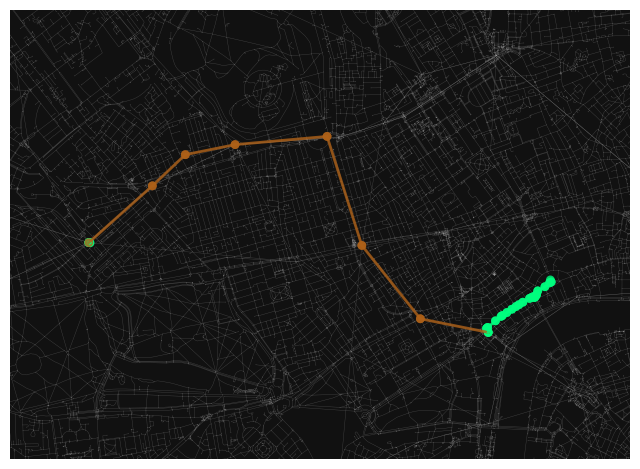

In [765]:
route = nx.shortest_path(G, origin, dest, weight='time') # print(route)
total_wk_time, total_tp_time, transfer = get_route_description(G, route, debug=False)

user_group = '_old'
route = nx.shortest_path(G, origin, dest, weight='time') # print(route)
total_wk_time, total_tp_time, transfer = get_route_description(G, route, debug=False)

user_group = '_young'
route = nx.shortest_path(G, origin, dest, weight='time') # print(route)
total_wk_time, total_tp_time, transfer = get_route_description(G, route, debug=False)

print(route)

route_chunks, route_colors = get_route_colors(G, route)
north, south, east, west = get_bbox_bound(route)
fig, ax = ox.plot_graph_routes(G, route_chunks, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
                            node_color='w', node_alpha=.3, node_size=.2, orig_dest_size=40, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.3, \
                            bbox=(north, south, east, west), dpi=300) 
fig.savefig(f"output_osmnx_paths/plan_{address_compact}_wk_weight_{WK_WEIGHT}.png", dpi=300, bbox_inches='tight')

In [766]:
# user_group = '_old'
# user_group = '_young'
# user_group = ''

# find stations that are within AWT of the origin and destination
# stations_near_origin, stations_near_dest = [], []
# for station in stations_osmid:
#     if nx.shortest_path_length(G_wk, origin, station, weight="time" + user_group) < ACCEPTABLE_WALKING_TIME:
#         stations_near_origin.append(station)
#     if nx.shortest_path_length(G_wk, dest, station, weight="time" + user_group) < ACCEPTABLE_WALKING_TIME:
#         stations_near_dest.append(station)

# print(f'Nearby station to {origin_address}: ')
# print(stations_near_origin)
# print(f'Nearby station to {dest_address}: ')
# print(stations_near_dest)
# print('')

In [767]:
# route_weight_dict = {}
# search_route_num = 0

# for station_dest in stations_near_dest:
#     for station_origin in stations_near_origin:
#         search_route_num += 1
#         logging.debug(f"Searching route {search_route_num} from {G.nodes[station_origin]['station_name']} to {G.nodes[station_dest]['station_name']}")
#         origin_to_station = nx.shortest_path(G_wk, origin, station_origin, weight="time" + user_group)
#         tp_route = nx.shortest_path(G, station_origin, station_dest, weight="time" + user_group)
#         station_to_dest = nx.shortest_path(G_wk, station_dest, dest, weight="time" + user_group)

#         route = origin_to_station[:-1] + tp_route + station_to_dest[1:]
#         total_wk_time, total_tp_time, transfer = get_route_description(G, route)
#         trip_time = total_wk_time + total_tp_time

#         route_weight_dict[trip_time] = route, trip_time

# logging.debug(f"Total number of routes searched: {search_route_num}\n\n")

# # make the final choice
# route_chunks, route_chunk_colors = [], []
# best_route, trip_time = route_weight_dict[min(route_weight_dict.keys())]
# print("👍🏻 Final Choice:")
# get_route_description(G, best_route, debug=False)
# print(f"Total Trip time: {trip_time} minutes\n\n")

# draw the best route
# route_chunks, route_colors = get_route_colors(G, route)
# north, south, east, west = get_bbox_bound(route)
# fig, ax = ox.plot_graph_routes(G, route_chunks, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
#                             node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                             bbox=(north, south, east, west), dpi=300) 
# fig.savefig(f"output_osmnx_paths/plan_best_{address_compact}.png", dpi=300, bbox_inches='tight')